In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score,confusion_matrix
import seaborn as sns



In [2]:

# Load the CSV file
file_path = 'creditcard.csv' 
df = pd.read_csv(file_path)

In [3]:

# Check for missing data
missing_data = df.isnull().sum()

# Display the count of missing values for each column
print("Missing Data:")
print(missing_data) 

Missing Data:
id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [4]:

# Calculate the total number of transactions
total_transactions = len(df)

# Count the number of fraudulent and non-fraudulent transactions
fraudulent_transactions = df['Class'].sum()  #  1 represents fraudulent
non_fraudulent_transactions = total_transactions - fraudulent_transactions

# Calculate the percentages
fraudulent_percentage = (fraudulent_transactions / total_transactions) * 100
non_fraudulent_percentage = (non_fraudulent_transactions / total_transactions) * 100

# Print the results
print("Percentage of fraudulent transactions:", fraudulent_percentage)
print("Percentage of non-fraudulent transactions:", non_fraudulent_percentage)

Percentage of fraudulent transactions: 50.0
Percentage of non-fraudulent transactions: 50.0


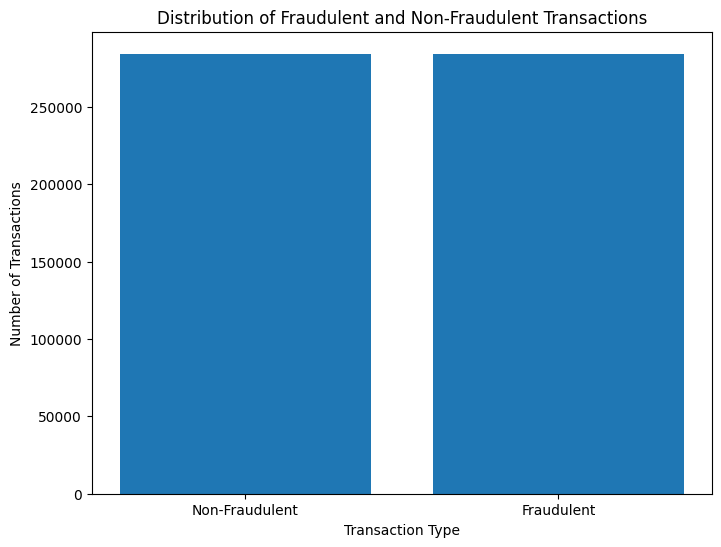

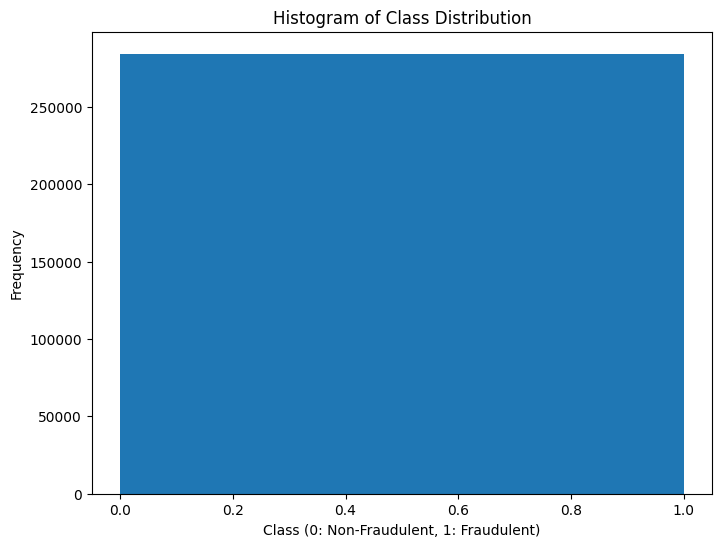

In [5]:

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Non-Fraudulent', 'Fraudulent'], df['Class'].value_counts())
plt.title("Distribution of Fraudulent and Non-Fraudulent Transactions")
plt.xlabel("Transaction Type")
plt.ylabel("Number of Transactions")
plt.show()

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(df['Class'], bins=2)  # Two bins for binary classification
plt.title("Histogram of Class Distribution")
plt.xlabel("Class (0: Non-Fraudulent, 1: Fraudulent)")
plt.ylabel("Frequency")
plt.show()

Balanced Classes: If your classes are roughly equal in size, random sampling is generally appropriate.


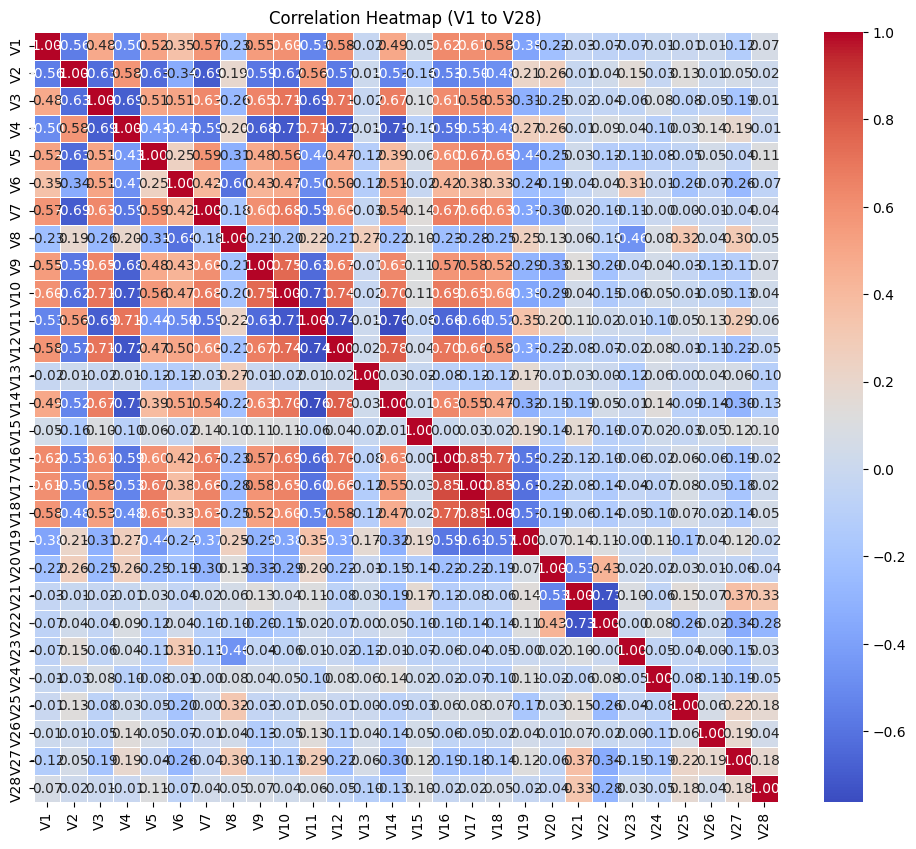

In [6]:

# Select only the columns V1 to V28 for correlation analysis
selected_columns = df.loc[:, 'V1':'V28']
# Calculate correlation matrix
correlation_matrix = selected_columns.corr()

# Create a heatmap to visualize correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap (V1 to V28)')
plt.show()

In [7]:

# Identify highly correlated features
threshold = 0.8  # Set your correlation threshold
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

# Exclude 'id' and 'Class' from dropping
highly_correlated_features -= {'id', 'Class', 'Amount'}

# Display highly correlated features
print("Highly Correlated Features:", list(highly_correlated_features))


Highly Correlated Features: ['V17', 'V18']


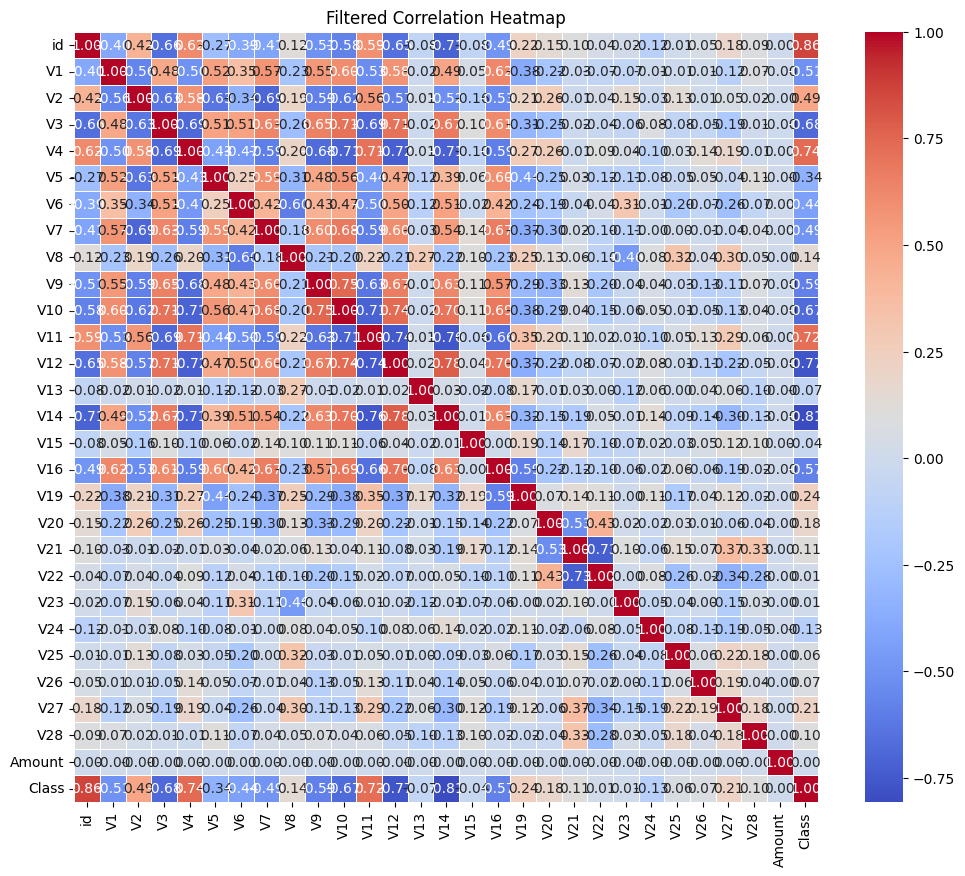

In [8]:

# Drop highly correlated and unselected features from the DataFrame
df_filtered = df.drop(columns=highly_correlated_features)

# Calculate correlation matrix for the filtered DataFrame
filtered_correlation_matrix = df_filtered.corr()

# Create a heatmap to visualize correlations of the filtered DataFrame
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Filtered Correlation Heatmap')
plt.show()


In [9]:

# Calculate the total number of transactions
total_transactions = len(df_filtered)

# Count the number of fraudulent and non-fraudulent transactions
fraudulent_transactions = df_filtered['Class'].sum()  # Assuming 1 represents fraudulent
non_fraudulent_transactions = total_transactions - fraudulent_transactions

# Calculate the percentages
fraudulent_percentage = (fraudulent_transactions / total_transactions) * 100
non_fraudulent_percentage = (non_fraudulent_transactions / total_transactions) * 100

# Print the results
print("Percentage of fraudulent transactions:", fraudulent_percentage)
print("Percentage of non-fraudulent transactions:", non_fraudulent_percentage)

Percentage of fraudulent transactions: 50.0
Percentage of non-fraudulent transactions: 50.0


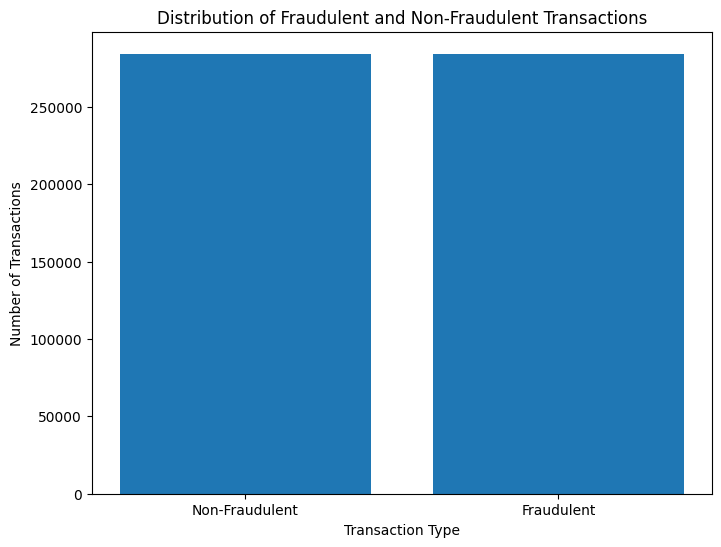

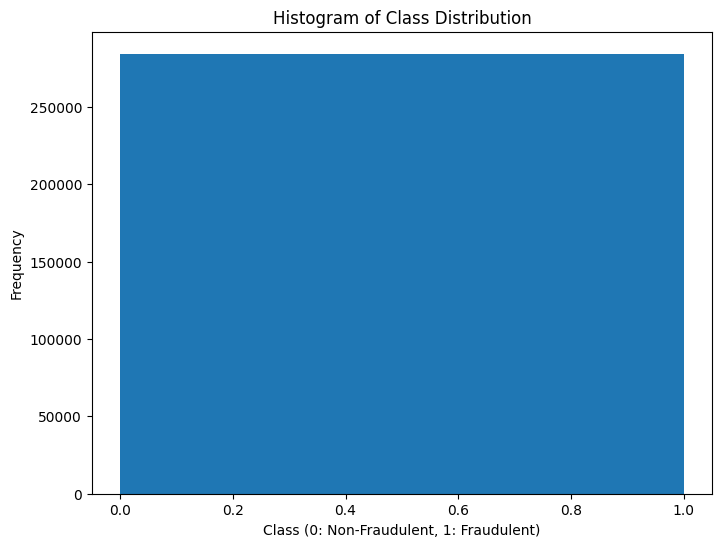

In [10]:

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Non-Fraudulent', 'Fraudulent'], df_filtered['Class'].value_counts())
plt.title("Distribution of Fraudulent and Non-Fraudulent Transactions")
plt.xlabel("Transaction Type")
plt.ylabel("Number of Transactions")
plt.show()

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(df_filtered['Class'], bins=2)  # Two bins for binary classification
plt.title("Histogram of Class Distribution")
plt.xlabel("Class (0: Non-Fraudulent, 1: Fraudulent)")
plt.ylabel("Frequency")
plt.show()

While the dataset overall has a 50/50 balance, random sampling could inadvertently create splits that don't accurately reflect this distribution.
Stratified sampling guarantees that both the training and testing sets maintain the same class proportions, ensuring consistency and preventing potential biases in model training and evaluation.

In [11]:

# Use StratifiedShuffleSplit for the initial split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(df_filtered.drop(["Class"], axis=1), df_filtered["Class"]):
    X_train, X_val_test = df_filtered.drop(["Class"], axis=1).iloc[train_index], df_filtered.drop(["Class"], axis=1).iloc[test_index]
    y_train, y_val_test = df_filtered["Class"].iloc[train_index], df_filtered["Class"].iloc[test_index]

# Further split the testing set into testing and validation
X_test, X_val, y_test, y_val = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)
X_val = np.ascontiguousarray(X_val)
y_val = np.ascontiguousarray(y_val)
X_test = np.ascontiguousarray(X_test)
y_test = np.ascontiguousarray(y_test)




In [12]:
# Calculate the number of fraudulent and non-fraudulent transactions in each set
fraud_train = y_train.sum()
non_fraud_train = len(y_train) - fraud_train
fraud_test = y_test.sum()
non_fraud_test = len(y_test) - fraud_test

# Print the distributions
print("Training set:")
print("  Number of fraudulent transactions:", fraud_train)
print("  Number of non-fraudulent transactions:", non_fraud_train)

print("Testing set:")
print("  Number of fraudulent transactions:", fraud_test)
print("  Number of non-fraudulent transactions:", non_fraud_test)


Training set:
  Number of fraudulent transactions: 227452
  Number of non-fraudulent transactions: 227452
Testing set:
  Number of fraudulent transactions: 28591
  Number of non-fraudulent transactions: 28272


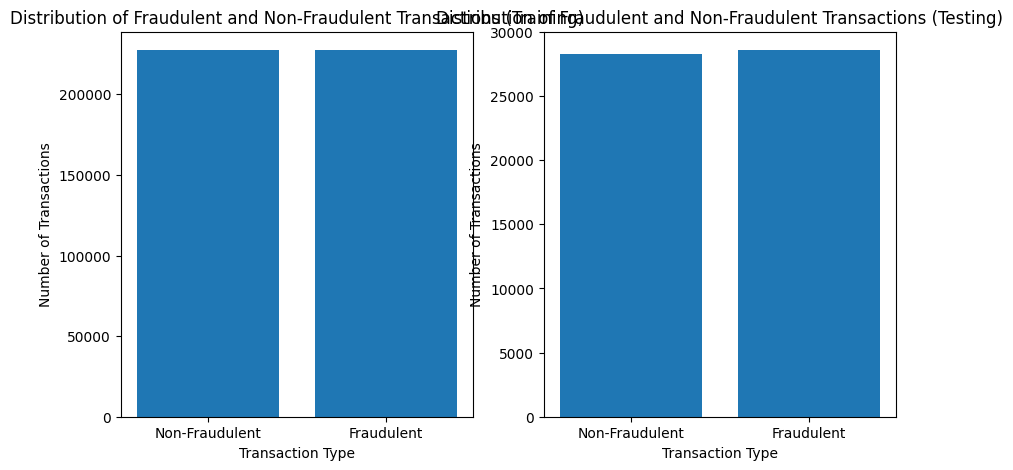

In [13]:

# Create bar plots
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(['Non-Fraudulent', 'Fraudulent'], [non_fraud_train, fraud_train])
plt.title("Distribution of Fraudulent and Non-Fraudulent Transactions (Training)")
plt.xlabel("Transaction Type")
plt.ylabel("Number of Transactions")

plt.subplot(1, 2, 2)
plt.bar(['Non-Fraudulent', 'Fraudulent'], [non_fraud_test, fraud_test])
plt.title("Distribution of Fraudulent and Non-Fraudulent Transactions (Testing)")
plt.xlabel("Transaction Type")
plt.ylabel("Number of Transactions")

plt.show()


Enhancing Recall: Even with a balanced split, oversampling can further improve recall, which is crucial in fraud detection to minimize missed fraudulent transactions.
Countering Algorithm Bias: Some algorithms might still exhibit a slight bias towards the majority class. Oversampling helps mitigate this.
Avoiding Overfitting: Your dataset is large enough that oversampling is unlikely to cause significant overfitting.
SMOTE: This well-established technique creates synthetic minority class samples, potentially leading to better generalization than simple random oversampling.


In [14]:

# # Apply SMOTE oversampling to the training set only
# sm = SMOTE(random_state=42)  # Set random_state for reproducibility
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [15]:
# # Calculate the number of fraudulent and non-fraudulent transactions in each set
# fraud_train = y_train_res.sum()
# non_fraud_train = len(y_train_res) - fraud_train
# # Print the distributions
# print("Training set:")
# print("  Number of fraudulent transactions:", fraud_train)
# print("  Number of non-fraudulent transactions:", non_fraud_train)


In [16]:

# Define and train KNN models with k=1 and k=3
knn_1 = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
# knn_1 = KNeighborsClassifier(n_neighbors=1)

knn_1.fit(X_train.values, y_train.values)

knn_3 = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
# knn_3 = KNeighborsClassifier(n_neighbors=3)

knn_3.fit(X_train.values, y_train.values)
# Predict labels on the validation set
y_pred_1 = knn_1.predict(X_val)
y_pred_3 = knn_3.predict(X_val)

# Evaluate performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC']

for metric in metrics:
    if metric == 'Accuracy':
        score_1 = accuracy_score(y_val, y_pred_1)
        score_3 = accuracy_score(y_val, y_pred_3)
    elif metric == 'Precision':
        score_1 = precision_score(y_val, y_pred_1)
        score_3 = precision_score(y_val, y_pred_3)
    elif metric == 'Recall':
        score_1 = recall_score(y_val, y_pred_1)
        score_3 = recall_score(y_val, y_pred_3)
    elif metric == 'F1':
        score_1 = f1_score(y_val, y_pred_1)
        score_3 = f1_score(y_val, y_pred_3)
        #  Area Under the Receiver Operating Characteristic curve for binary classification
    elif metric == 'AUC-ROC':
        score_1 = roc_auc_score(y_val, y_pred_1)
        score_3 = roc_auc_score(y_val, y_pred_3)
    print(f"{metric} for k=1: {score_1:.4f}")
    print(f"{metric} for k=3: {score_3:.4f}")

Accuracy for k=1: 0.9983
Accuracy for k=3: 0.9990
Precision for k=1: 0.9984
Precision for k=3: 0.9998
Recall for k=1: 0.9981
Recall for k=3: 0.9982
F1 for k=1: 0.9983
F1 for k=3: 0.9990
AUC-ROC for k=1: 0.9983
AUC-ROC for k=3: 0.9990


theyre on top of each other 

on testing set 

Accuracy for k=1: 0.9984
Accuracy for k=3: 0.9991
Precision for k=1: 0.9984
Precision for k=3: 0.9998
Recall for k=1: 0.9983
Recall for k=3: 0.9983
F1 for k=1: 0.9984
F1 for k=3: 0.9991
AUC-ROC for k=1: 0.9984
AUC-ROC for k=3: 0.9991


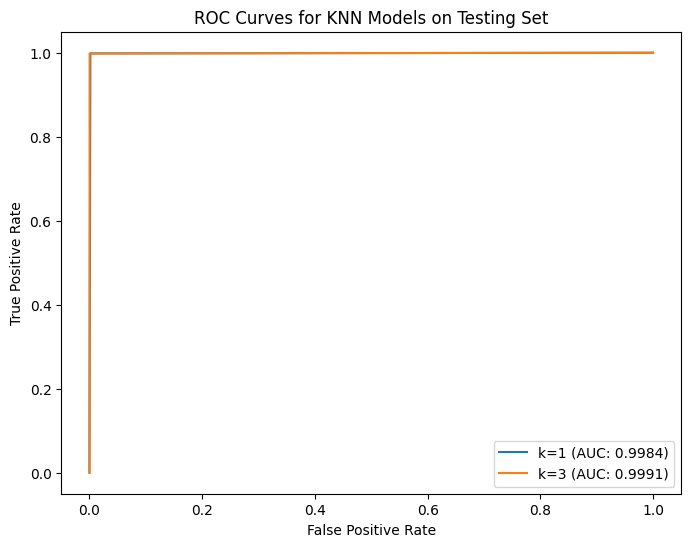

AUC-ROC for k=1: 0.9984
AUC-ROC for k=3: 0.9991


In [25]:

# Predict labels on the testing set
y_test_pred_1 = knn_1.predict(X_test)
y_test_pred_3 = knn_3.predict(X_test)

# Evaluate performance metrics on the testing set
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC']

for metric in metrics:
    if metric == 'Accuracy':
        score_1 = accuracy_score(y_test, y_test_pred_1)
        score_3 = accuracy_score(y_test, y_test_pred_3)
    elif metric == 'Precision':
        score_1 = precision_score(y_test, y_test_pred_1)
        score_3 = precision_score(y_test, y_test_pred_3)
    elif metric == 'Recall':
        score_1 = recall_score(y_test, y_test_pred_1)
        score_3 = recall_score(y_test, y_test_pred_3)
    elif metric == 'F1':
        score_1 = f1_score(y_test, y_test_pred_1)
        score_3 = f1_score(y_test, y_test_pred_3)
    elif metric == 'AUC-ROC':
        fpr_1, tpr_1, _ = roc_curve(y_test, y_test_pred_1)
        fpr_3, tpr_3, _ = roc_curve(y_test, y_test_pred_3)
        roc_auc_1 = auc(fpr_1, tpr_1)
        roc_auc_3 = auc(fpr_3, tpr_3)
        print(f"AUC-ROC for k=1: {roc_auc_1:.4f}")
        print(f"AUC-ROC for k=3: {roc_auc_3:.4f}")

        # Plot ROC curves
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_1, tpr_1, label=f"k=1 (AUC: {roc_auc_1:.4f})")
        plt.plot(fpr_3, tpr_3, label=f"k=3 (AUC: {roc_auc_3:.4f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curves for KNN Models on Testing Set")
        plt.legend()
        plt.show()

    print(f"{metric} for k=1: {score_1:.4f}")
    print(f"{metric} for k=3: {score_3:.4f}")


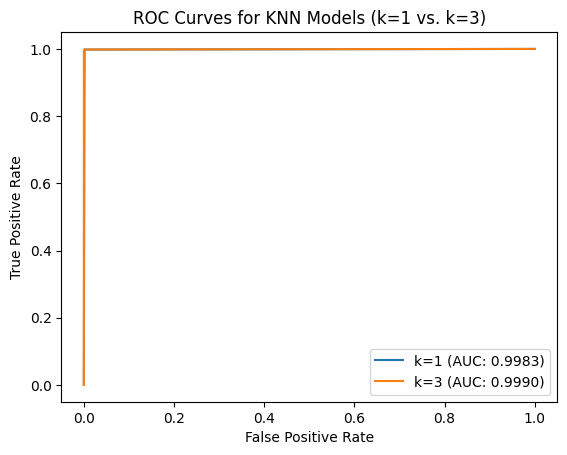

In [22]:


# Generate ROC curves for both models
fpr_1, tpr_1, thresholds_1 = roc_curve(y_val, y_pred_1)
fpr_3, tpr_3, thresholds_3 = roc_curve(y_val, y_pred_3)

# Plot the curves
plt.plot(fpr_1, tpr_1, label=f"k=1 (AUC: {roc_auc_score(y_val, y_pred_1):.4f})")
plt.plot(fpr_3, tpr_3, label=f"k=3 (AUC: {roc_auc_score(y_val, y_pred_3):.4f})")

# Add labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for KNN Models (k=1 vs. k=3)")
plt.legend()
plt.show()

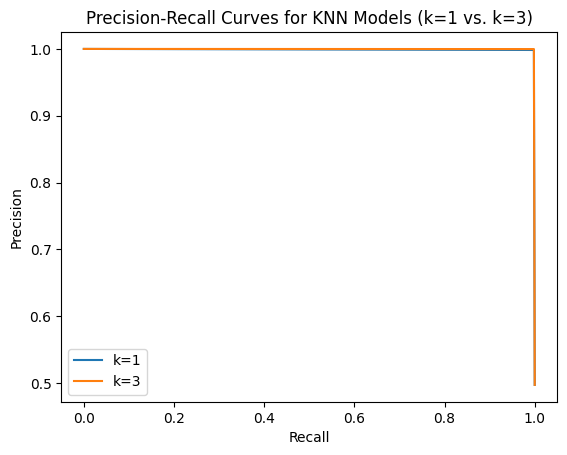

In [20]:
# Generate precision-recall curves for both models
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_val, y_pred_1)
precision_3, recall_3, thresholds_3 = precision_recall_curve(y_val, y_pred_3)

# Plot the curves
plt.plot(recall_1, precision_1, label=f"k=1")
plt.plot(recall_3, precision_3, label=f"k=3")

# Add labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for KNN Models (k=1 vs. k=3)")
plt.legend()
plt.show()

Confusion Matrix for k=1:
[[28546    45]
 [   53 28219]]

Confusion Matrix for k=3:
[[28585     6]
 [   51 28221]]


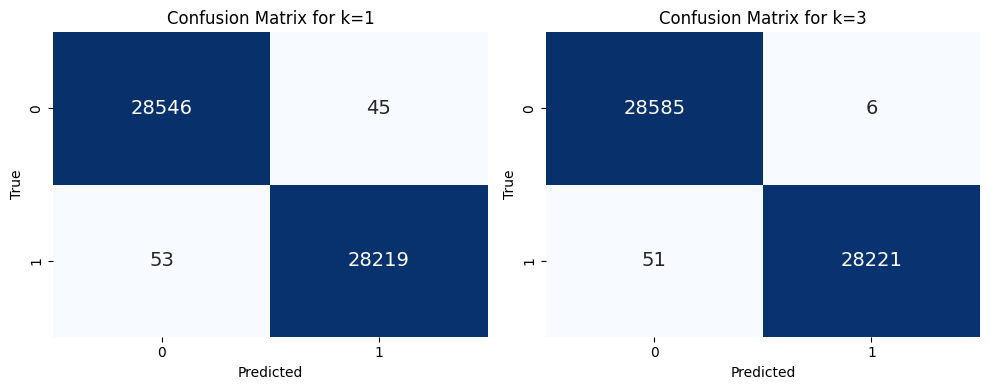

In [24]:
# Generate confusion matrices for both models
cm_1 = confusion_matrix(y_val, y_pred_1)
cm_3 = confusion_matrix(y_val, y_pred_3)

# Print the confusion matrices
print("Confusion Matrix for k=1:")
print(cm_1)
print("\nConfusion Matrix for k=3:")
print(cm_3)
# Plot the confusion matrices using seaborn
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm_1, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 14})
plt.title("Confusion Matrix for k=1")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 2, 2)
sns.heatmap(cm_3, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 14})
plt.title("Confusion Matrix for k=3")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()
